# Time-domain simulation via harmonic BEM

OptimUS provides simulations of harmonic acoustic waves. Modelling the time-dependent propagation of acoustic waves can be performed for bandlimited signals via Fourier transforms. This tutorial demonstrates how to define an acoustic pulse, calculate its spectrum, limit the dominant frequencies, perform harmonic BEM, and inverse Fourier transform the results to obtain time-dependent results.

In [1]:
import sys
sys.path.append('..')

In [2]:
%matplotlib inline
import optimus
import numpy as np
import matplotlib.pyplot as plt

Let us use the FFT functionality provided by NumPy for the Fourier transform and its inverse, key to transforming time-dependent signals to harmonic waves and vice versa. Since we use real-valued signals only, let us load the real-valued versions of the (inverse) FFT transform.

The use of the SciPy FFT functionality is discouraged. The Docker image has a deprecated SciPy version due to legacy dependencies with other libraries and the current SciPy installation has different formatting conventions to NumPy and the latest SciPy implementations.

In [3]:
from numpy.fft import rfft, irfft, rfftfreq

## Define the physical parameters and computational domain

Let us consider a spatial domain given by a sphere of a fixed radius [m] that consists of a homogeneous material embedded in an unbounded region. The extent of the visualisation domain [m] and its resolution needs to be specified as well.

In [4]:
RADIUS = 5e-3

EXTERIOR_DOMAIN = "water"
INTERIOR_DOMAIN = "bone (cortical)"

EXTENT = (-15e-3, 15e-3, -15e-3, 15e-3)
RESOLUTION = (200, 200)

Let us define the duration [s] of the simulation and the number of time samples.

The number of samples in the time series is also the number of discrete frequencies in the FFT. A longer time length will increase the resolution of frequencies in the FFT.

In [5]:
N_SAMPLES = 200
TIME_LENGTH = 30e-6

### Preprocess the temporal domain

Calculate the time samples and the frequency content available for this domain.

In [6]:
sampling_rate = N_SAMPLES / TIME_LENGTH
time_samples = np.linspace(0, TIME_LENGTH, N_SAMPLES, endpoint=False)

The frequencies available for the FFT depend on the time length and resolution only, and can be retrieved with the function ```rfftfreq```.

In [7]:
freqs_fft = rfftfreq(N_SAMPLES, 1 / sampling_rate)
print("The FFT considers", N_SAMPLES//2+1, "frequencies between zero and", N_SAMPLES/2/TIME_LENGTH,
      "with a step of", 1/TIME_LENGTH, "Hz.")

The FFT considers 101 frequencies between zero and 3333333.333333333 with a step of 33333.333333333336 Hz.


### Preprocess the spatial domain

Create the materials for the interior and exterior domains.

In [8]:
material_ext = optimus.material.load_material(EXTERIOR_DOMAIN)
material_int = optimus.material.load_material(INTERIOR_DOMAIN)

## Verification for a sinusoidal wave

A periodic sinusoidal wave in time-domain has only one frequency. Hence, it reduces to a single harmonic simulation. Let us verify the Fourier transforms in this situation.

We define the pulse as $\cos(\omega t)$ for $\omega$ the angular frequency. Let us define the frequency $f=\omega/(2\pi)$ [Hz].

In [9]:
HARMONIC_FREQUENCY = 200e3

In [10]:
pulse_cosine_time = np.cos(2*np.pi * HARMONIC_FREQUENCY * time_samples)

pulse_cosine_fft = rfft(pulse_cosine_time)
pulse_cosine_ifft = irfft(pulse_cosine_fft)

The inverse Fourier transform of the Fourier transform should equal the original series, except for numerical errors. Let us plot both series.

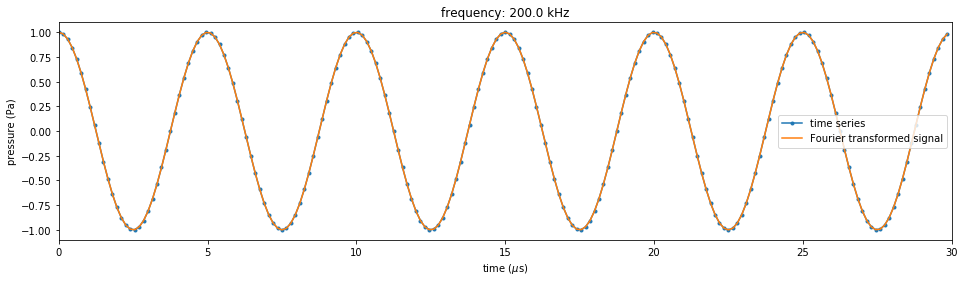

In [11]:
fig = plt.figure(figsize=(16,4))

t_scaling = 1e-6
f_scaling = 1e3

plt.plot(time_samples/t_scaling, pulse_cosine_time, marker='.', label='time series')
plt.plot(time_samples/t_scaling, pulse_cosine_ifft, marker=None, label='Fourier transformed signal')

plt.xlim([0, TIME_LENGTH/t_scaling])

plt.xlabel('time ($\mu$s)')
plt.ylabel('pressure (Pa)')
plt.title('frequency: '+str(HARMONIC_FREQUENCY/f_scaling)+' kHz')
plt.legend()

plt.show()

Let us check the spectral content of the pulse, which is expected to be a sharp peak at the frequency of the cosine wave. The sharpness of the peak depends on the resolution of the time series. The power is normalized by a factor of $2/N$.

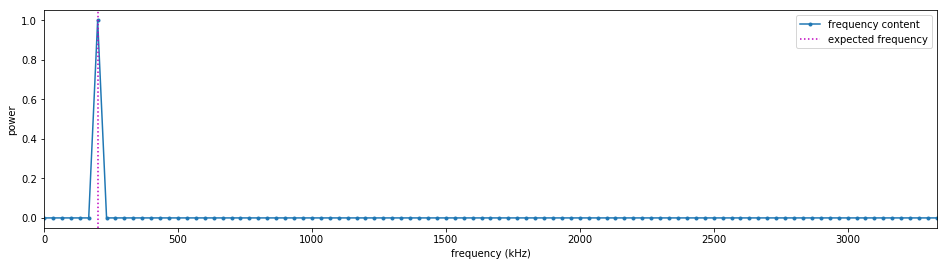

In [12]:
fig = plt.figure(figsize=(16,4))

f_scaling = 1e3
p_scaling = N_SAMPLES/2

pulse_plot = np.abs(pulse_cosine_fft)/p_scaling
plt.plot(freqs_fft/f_scaling, pulse_plot, marker='.', label='frequency content')
plt.axvline(HARMONIC_FREQUENCY/f_scaling, color='m', linestyle=':', label='expected frequency')

plt.xlim(0,max(freqs_fft)/f_scaling)

plt.xlabel('frequency (kHz)')
plt.ylabel('power')
plt.legend()

plt.show()

Let us simulate harmonic wave propagation in the positive $x$-direction at the dominant frequency with the Boundary Element Method (BEM) implemented in OptimUS. We will use a standard model. See the other tutorials, specifically the `Basic Model` for more information about the numerical method.

In [13]:
frequency_max_idx = np.argmax(np.abs(pulse_cosine_fft))
frequency_max_val = freqs_fft[frequency_max_idx]

In [14]:
source = optimus.source.create_planewave(frequency_max_val, direction=(1,0,0))
geometry = optimus.geometry.shapes.Sphere(radius=RADIUS, element_size=1.5e-3)
material_ext = optimus.material.load_material('water')
material_int = optimus.material.load_material('bone (cortical)')
model = optimus.model.create_default_model(source, geometry, material_ext, material_int)
model.solve()
postprocess_plane = optimus.postprocess.VisualisePlane(model)
postprocess_plane.create_computational_grid(bounding_box=EXTENT, resolution=RESOLUTION)
postprocess_plane.compute_fields()

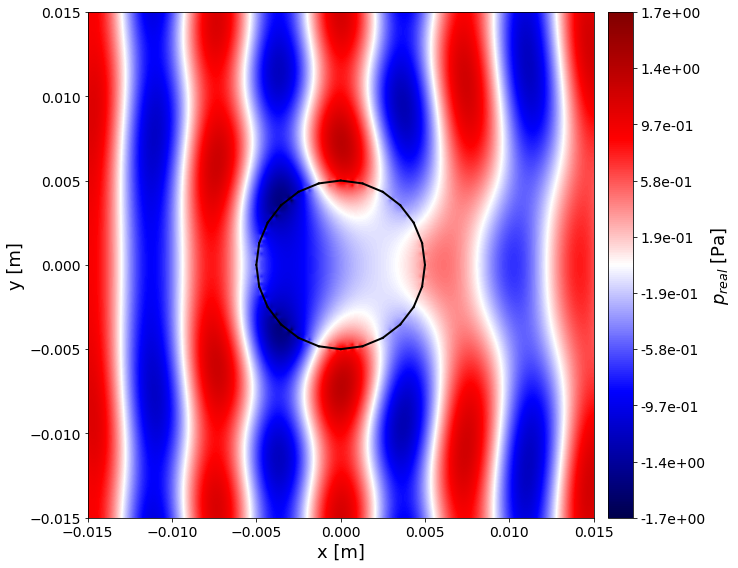

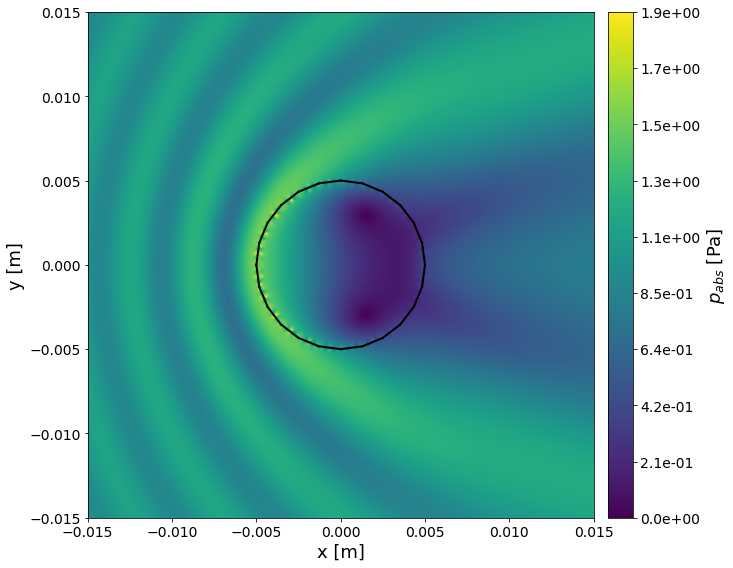

In [15]:
figs = optimus.postprocess.plot_pressure_field(postprocess_plane)

OptimUS uses the BEMPP library for the BEM simulations. The harmonic waves in this library are achieved by eliminating an $e^{-\imath\omega t}$ time dependency. Specifically, a time-dependent wave can be retrieved as $$p(\mathbf{x},t) = \Re\left(u(\mathbf{x}) e^{-\imath\omega t}\right)$$ for $u$ the harmonic pressure field and $\omega$ the angular frequency.

In [16]:
harmonic_field = postprocess_plane.total_field_imshow[:, :, np.newaxis]
time_interval = time_samples[np.newaxis, np.newaxis, :]
spacetime_field = np.real(harmonic_field * np.exp(-1j * 2*np.pi*frequency_max_val * time_interval))

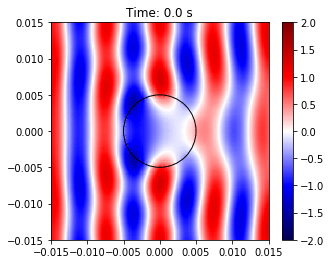

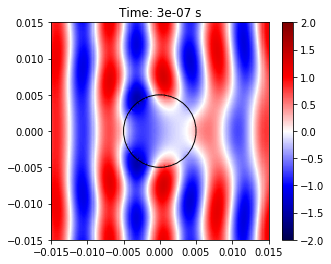

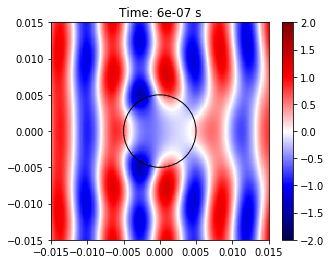

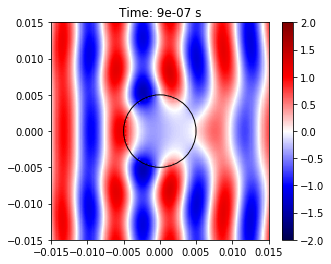

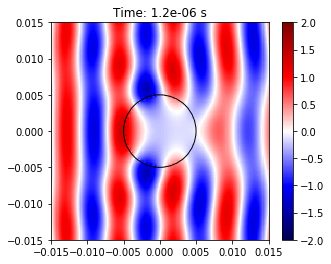

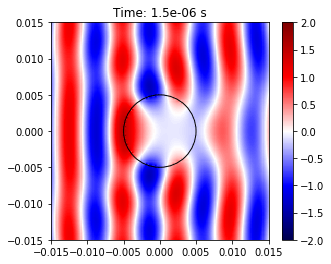

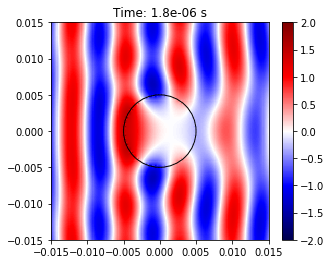

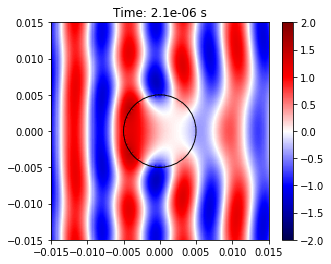

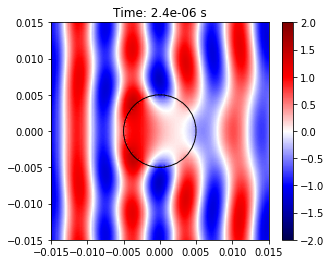

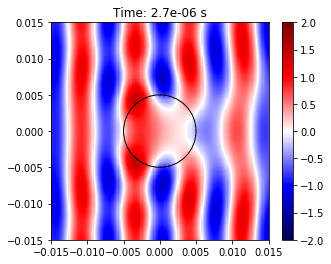

In [17]:
plot_skip = 2
plot_end = 20

for t in range(0, plot_end, plot_skip):
    fig = plt.figure(figsize=(5,4))

    field_plot = spacetime_field[:,:,t]
    plt.imshow(field_plot, extent=EXTENT, clim=(-2, 2), cmap="seismic")
    fig.gca().add_artist(plt.Circle((0,0), RADIUS, edgecolor='k', fill=False))
    
    plt.title("Time: "+str(time_samples[t])+" s")
    plt.colorbar()

    plt.show()

The time-dependent field can also be calculated with the inverse Fourier transform. However, NumPy uses a different sign convention, extracting $e^{\imath\omega t}$ time dependencies. Hence, the complex conjugate of the harmonic field needs to be used.

In [18]:
field_frequency_terms = np.zeros(RESOLUTION + freqs_fft.shape, dtype='complex')
field_frequency_terms[:, :, frequency_max_idx] = postprocess_plane.total_field_imshow * np.conj(pulse_cosine_fft[frequency_max_idx])

spacetime_field_ifft = irfft(np.conj(field_frequency_terms))

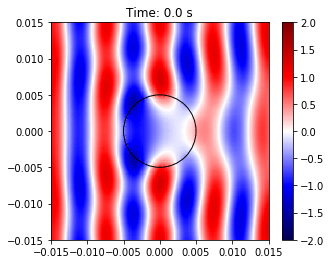

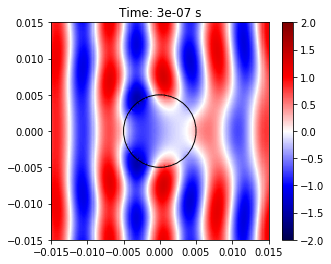

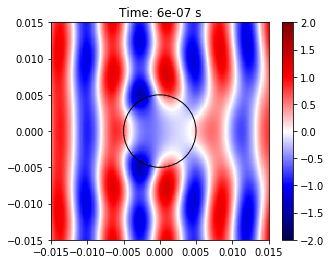

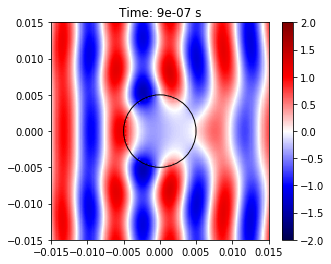

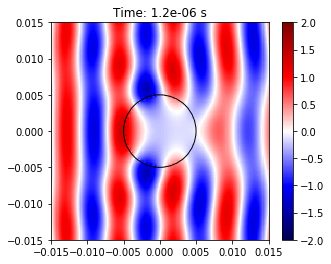

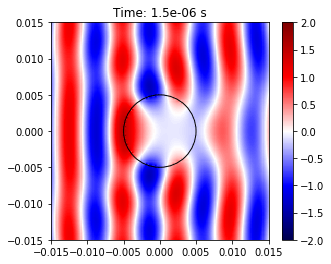

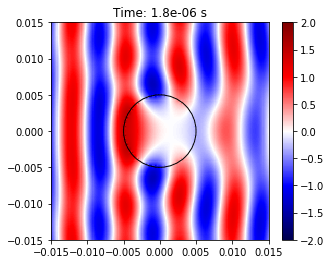

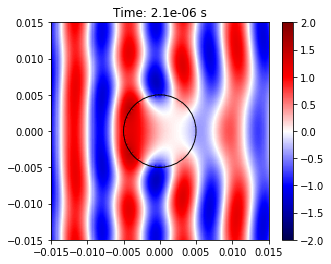

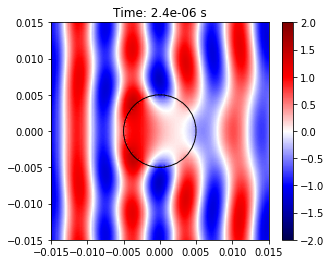

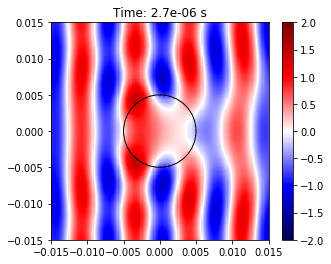

In [19]:
plot_skip = 2
plot_end = 20

for t in range(0, plot_end, plot_skip):
    fig = plt.figure(figsize=(5,4))

    field_plot = spacetime_field_ifft[:,:,t]
    plt.imshow(field_plot, extent=EXTENT, clim=(-2, 2), cmap="seismic")
    fig.gca().add_artist(plt.Circle((0,0), RADIUS, edgecolor='k', fill=False))
    
    plt.title("Time: "+str(time_samples[t])+" s")
    plt.colorbar()

    plt.show()

The inverse Fourier transformed field indeed travels in the positive $x$-direction and is consistent with the manually transformed field.

## Create a Gaussian modulated sinusoidal pulse

The Fourier transform is a powerful tool to simulate bandlimited pulses with harmonic calculations. To showcase this functionality, let us consider a sinusoidal pulse modulated with a Gaussian window. Specifically, the pulse is defined as $$s(t) = \frac1{\sigma \sqrt{2\pi}} e^{-\frac{(t-\mu)^2}{2\sigma^2}} \cos(\omega(t-\mu))$$ where $\mu$ is a delay, $\sigma$ the standard deviation of the envelope, and $\omega$ again the angular frequency.

In [20]:
def modulated_gaussian_pulse(t, f, mu=0, sigma=1):
    omega = 2*np.pi * f
    mu_array = np.atleast_1d(mu)[:, np.newaxis]
    t_array = np.atleast_1d(t)[np.newaxis, :]
    return 1/(sigma*np.sqrt(2*np.pi)) * np.exp(-(t_array-mu_array)**2/(2*sigma**2)) * np.cos(omega*(t_array-mu_array))

The incident field is a Gaussian modulated sinusoidal plane wave field, for which we need to define the center frequency [Hz], pulse width [s], center point [m], and propagation direction. Here, we define the center point as the three-dimensional location where the pulse will attain its maximum at $t=0$.

In [21]:
PULSE_FREQUENCY = 300e3
PULSE_WIDTH = 1.5e-6

PULSE_CENTER = (-10e-3,0,0)
DIRECTION = (1,0,0)

### Visualise the pulse and analyse its spectrum

Let us plot the time evolution of the pulse in the global origin and calculate its frequency spectrum.

In [22]:
delay = -np.dot(PULSE_CENTER, DIRECTION) / material_ext.speed_of_sound
pulse_gaussian_time = modulated_gaussian_pulse(time_samples, PULSE_FREQUENCY, mu=delay, sigma=PULSE_WIDTH).squeeze()

pulse_gaussian_fft = rfft(pulse_gaussian_time)

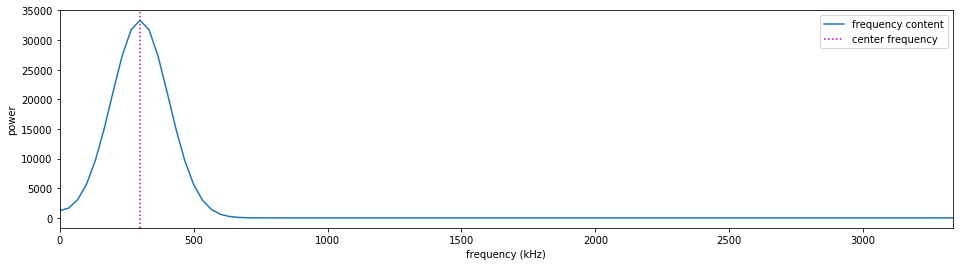

In [23]:
fig = plt.figure(figsize=(16,4))

f_scaling = 1e3
p_scaling = N_SAMPLES/2

pulse_plot = np.abs(pulse_gaussian_fft)/p_scaling
plt.plot(freqs_fft/f_scaling, pulse_plot, label='frequency content')
plt.axvline(PULSE_FREQUENCY/f_scaling, color='m', linestyle=':', label='center frequency')

plt.xlim(0,max(freqs_fft)/f_scaling)

plt.xlabel('frequency (kHz)')
plt.ylabel('power')
plt.legend()

plt.show()

The spectral plot shows a power peak at the expected center frequency of the modulated Gaussian sinusoid. The power drops down exponentially with frequency until reaching machine precision, as expected.

The frequency range for the harmonic simulation needs to be limited to avoid prohibitively long calculation times. For this, we define a cutoff threshold for the power spectrum. The threshold is defined as the fraction of the maximum power to be included.

In [24]:
THRESHOLD = 0.05

In [25]:
max_power = np.max(np.abs(pulse_gaussian_fft))
dominant_power = np.abs(pulse_gaussian_fft) >= max_power * THRESHOLD
idx_sweep = np.where(dominant_power)[0]
freq_sweep = freqs_fft[idx_sweep]

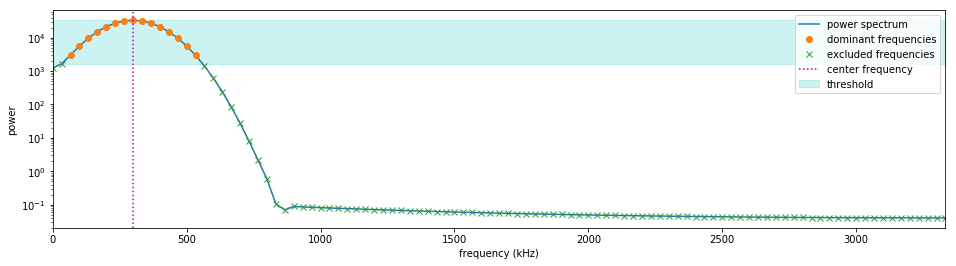

In [26]:
fig = plt.figure(figsize=(16,4))

f_scaling = 1e3
p_scaling = N_SAMPLES/2

pulse_plot = np.abs(pulse_gaussian_fft)/p_scaling
plt.semilogy(freqs_fft/f_scaling, pulse_plot,
             label='power spectrum')
plt.semilogy(freq_sweep/f_scaling, pulse_plot[idx_sweep],
             marker='o', linestyle='', label='dominant frequencies')
plt.semilogy(freqs_fft[np.logical_not(dominant_power)]/f_scaling, pulse_plot[np.logical_not(dominant_power)],
             marker='x', linestyle='', label='excluded frequencies')
plt.axvline(PULSE_FREQUENCY/f_scaling,
            color='m', linestyle=':', label='center frequency')
plt.fill_between(freqs_fft/f_scaling, max_power*THRESHOLD/p_scaling, max_power/p_scaling,
                 color='c', alpha=0.2, label='threshold')

plt.xlim(0,max(freqs_fft)/f_scaling)

plt.xlabel('frequency (kHz)')
plt.ylabel('power')
plt.legend()

plt.show()

In [27]:
print("There are", len(freq_sweep), "frequencies inside the threshold:\n", freq_sweep)

There are 15 frequencies inside the threshold:
 [ 66666.66666667 100000.         133333.33333333 166666.66666667
 200000.         233333.33333333 266666.66666667 300000.
 333333.33333333 366666.66666667 400000.         433333.33333333
 466666.66666667 500000.         533333.33333333]


Let's check the accuracy of the windowing of the Fourier transform. A lower threshold will increase the accuracy of the harmonic approximation but will also increase the simulation time.

In [28]:
from copy import deepcopy

dummy = np.zeros_like(pulse_gaussian_fft)
dummy[idx_sweep] = deepcopy(pulse_gaussian_fft[idx_sweep])
pulse_gaussian_ifft_sweep = irfft(dummy)

print("Relative error in windowed Fourier transform:",
      np.linalg.norm(pulse_gaussian_ifft_sweep - pulse_gaussian_time) / np.linalg.norm(pulse_gaussian_time))

Relative error in windowed Fourier transform: 0.030777086248510197


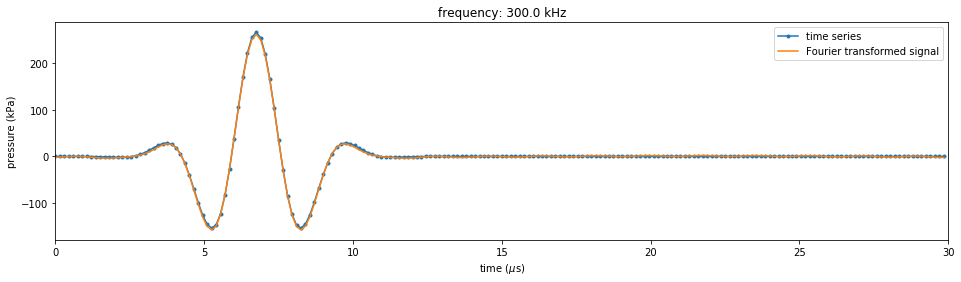

In [29]:
fig = plt.figure(figsize=(16,4))

t_scaling = 1e-6
p_scaling = 1e3
f_scaling = 1e3

plt.plot(time_samples/t_scaling, pulse_gaussian_time/p_scaling, marker='.', label='time series')
plt.plot(time_samples/t_scaling, pulse_gaussian_ifft_sweep/p_scaling, marker=None, label='Fourier transformed signal')

plt.xlim([0, TIME_LENGTH/t_scaling])

plt.xlabel('time ($\mu$s)')
plt.ylabel('pressure (kPa)')
plt.title('frequency: '+str(PULSE_FREQUENCY/f_scaling)+' kHz')
plt.legend()

plt.show()

### Perform BEM simulations for all dominant frequencies

Let us simulate harmonic wave propagation for all dominant frequencies with the BEM. We will use a triangular surface grid with a frequency-dependent mesh width. At each frequency in the sweep, a new grid is created with a fixed number of elements per wavelength. This means that the BEM calculations become increasingly expensive for higher frequencies. Furthermore, to represent the geometry accurately, the mesh width should not exceed a third of the radius.

In [30]:
PPWL = 3

In [31]:
import time

if material_ext.speed_of_sound < material_int.speed_of_sound:
    material_cmin = material_ext
else:
    material_cmin = material_int

fields_gaussian_inc = []
fields_gaussian_tot = []

print("Perform", len(freq_sweep),"BEM simulations.")

for sim, f in enumerate(freq_sweep):
    print("\nStart simulation", sim+1, "for frequency", f)
    t_start = time.time()
    
    h = min(material_cmin.compute_wavelength(f) / PPWL, RADIUS / 3)
    geometry = optimus.geometry.shapes.Sphere(radius=RADIUS, element_size=h)
    print("The surface grid has a mesh width of", h, "and consists of", geometry.number_of_vertices(), "nodes.")

    source_gaussian = optimus.source.create_planewave(f, direction=DIRECTION)
    
    model_gaussian = optimus.model.create_default_model(source_gaussian, geometry, material_ext, material_int)
    model_gaussian.solve()
    
    postprocess_plane_gaussian = optimus.postprocess.VisualisePlane(model_gaussian)
    postprocess_plane_gaussian.create_computational_grid(bounding_box=EXTENT, resolution=RESOLUTION)
    postprocess_plane_gaussian.compute_fields()

    fields_gaussian_inc.append(postprocess_plane_gaussian.incident_field_imshow)
    fields_gaussian_tot.append(postprocess_plane_gaussian.total_field_imshow)
    
    print("Finished simulation after", time.time() - t_start, "seconds.")

Perform 15 BEM simulations.

Start simulation 1 for frequency 66666.66666666666
The surface grid has a mesh width of 0.0016666666666666668 and consists of 180 nodes.
Finished simulation after 50.05089259147644 seconds.

Start simulation 2 for frequency 99999.99999999999
The surface grid has a mesh width of 0.0016666666666666668 and consists of 180 nodes.
Finished simulation after 13.042097568511963 seconds.

Start simulation 3 for frequency 133333.3333333333
The surface grid has a mesh width of 0.0016666666666666668 and consists of 180 nodes.
Finished simulation after 13.841103076934814 seconds.

Start simulation 4 for frequency 166666.66666666663
The surface grid has a mesh width of 0.0016666666666666668 and consists of 180 nodes.
Finished simulation after 27.833442211151123 seconds.

Start simulation 5 for frequency 199999.99999999997
The surface grid has a mesh width of 0.0016666666666666668 and consists of 180 nodes.
Finished simulation after 25.15769624710083 seconds.

Start simul

Notice that only the fields are stored for each harmonic simulation. The models could be stored as well, but at significant memory consumption since the postprocess object stores the model and hence the discretisation matrix.

Let's visualise the incident field for the harmonic simulation and the total pressure field calculated by the BEM at each dominant frequency.

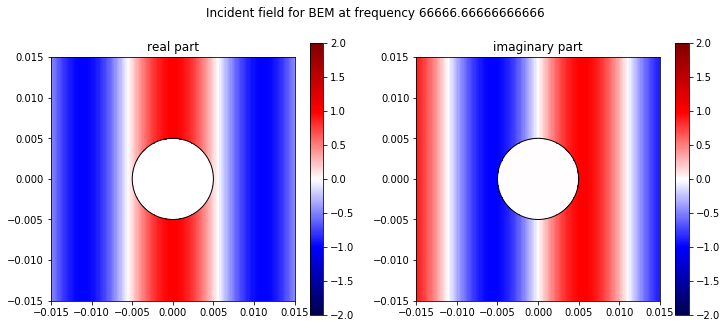

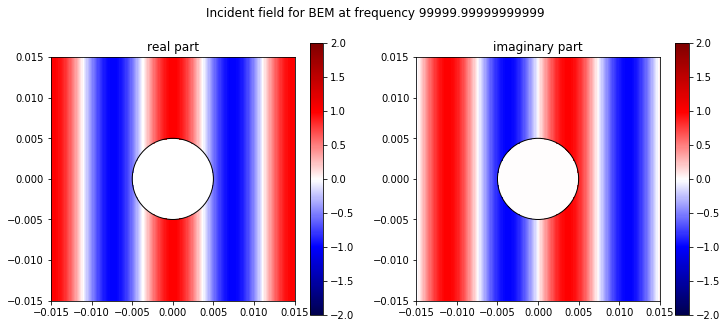

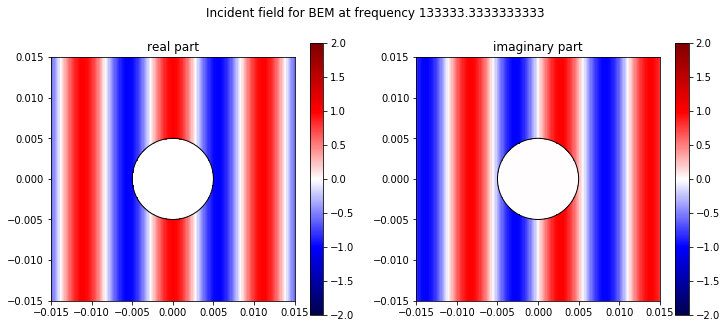

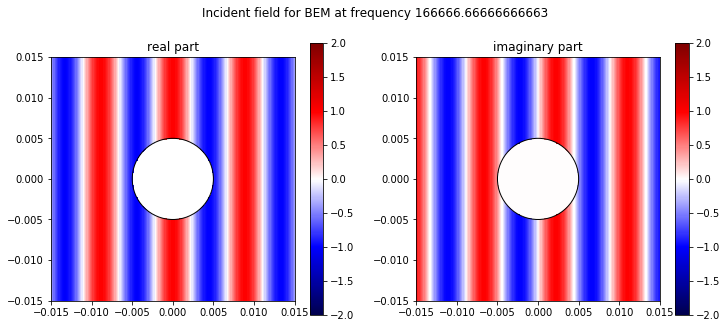

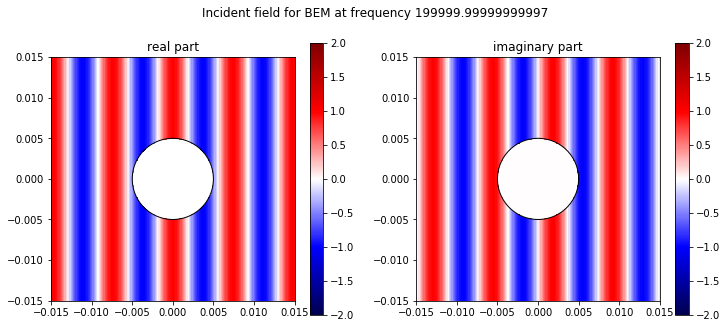

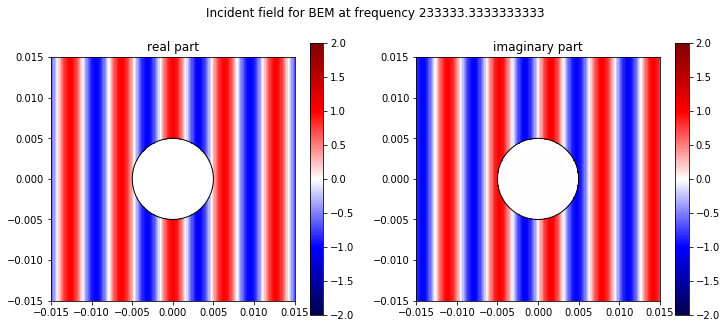

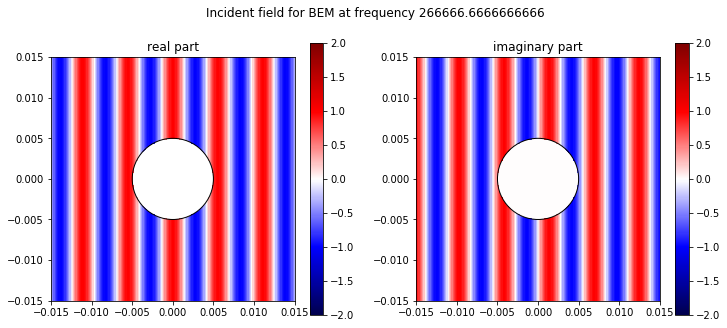

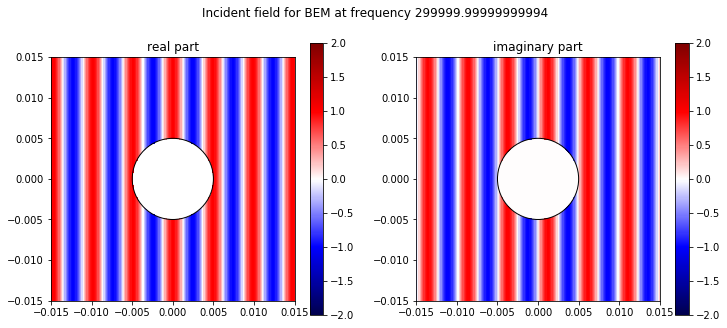

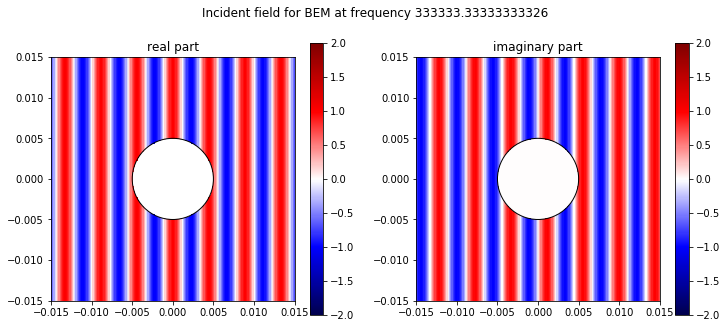

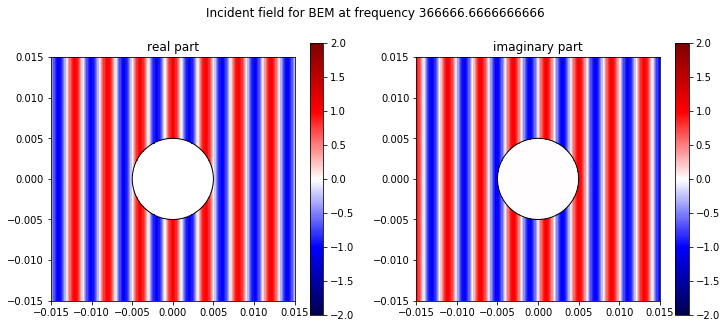

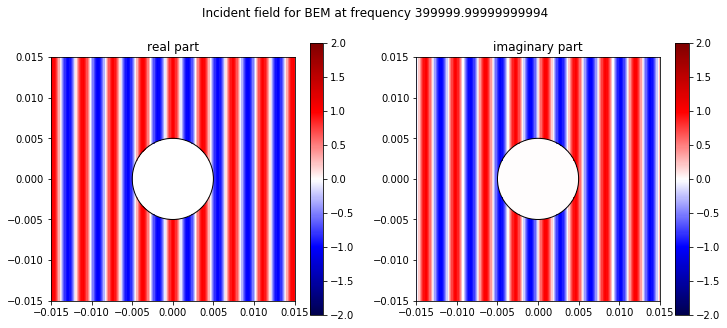

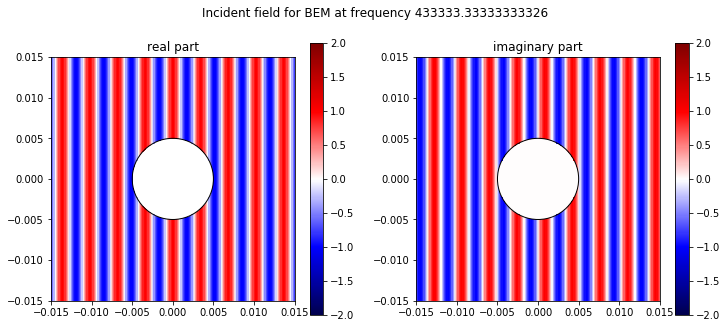

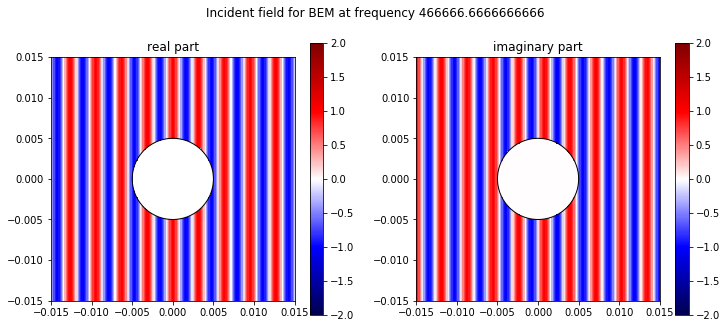

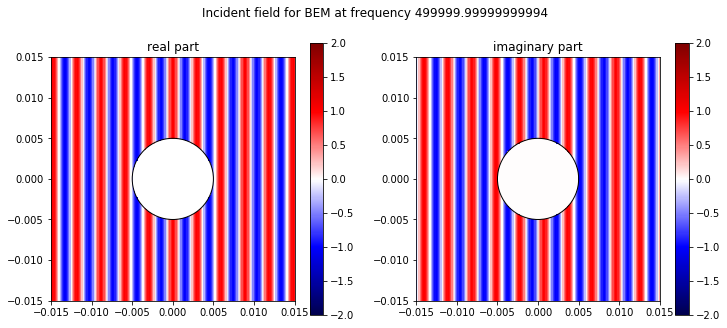

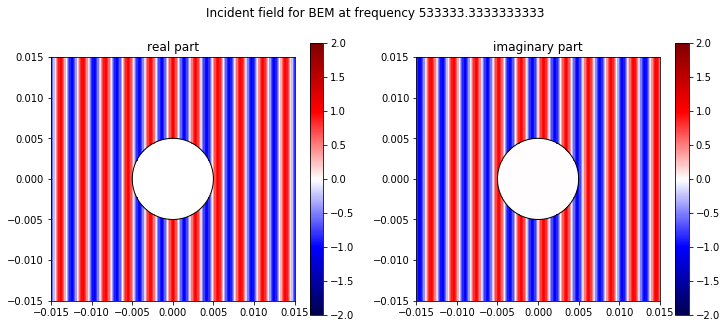

In [32]:
for count, field_plot in enumerate(fields_gaussian_inc):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

    im1 = ax1.imshow(np.real(field_plot), extent=EXTENT, clim=(-2, 2), cmap="seismic")
    ax1.add_artist(plt.Circle((0,0), RADIUS, edgecolor='k', fill=False))
    plt.colorbar(im1, ax=ax1)
    ax1.set_title('real part')

    im2 = ax2.imshow(np.imag(field_plot), extent=EXTENT, clim=(-2, 2), cmap="seismic")
    ax2.add_artist(plt.Circle((0,0), RADIUS, edgecolor='k', fill=False))
    plt.colorbar(im2, ax=ax2)
    ax2.set_title('imaginary part')

    fig.suptitle("Incident field for BEM at frequency "+str(freq_sweep[count]))

    plt.show()

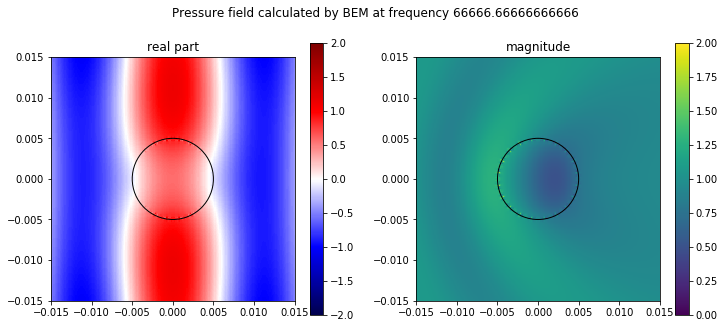

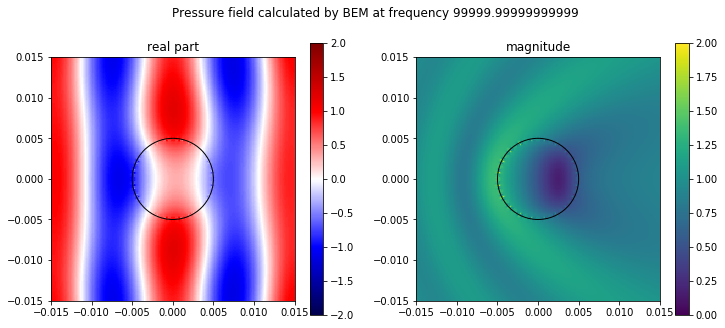

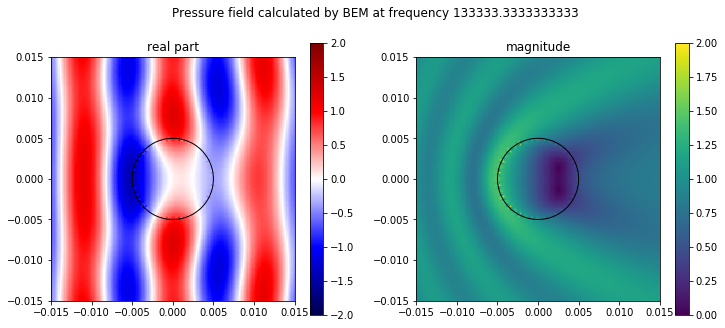

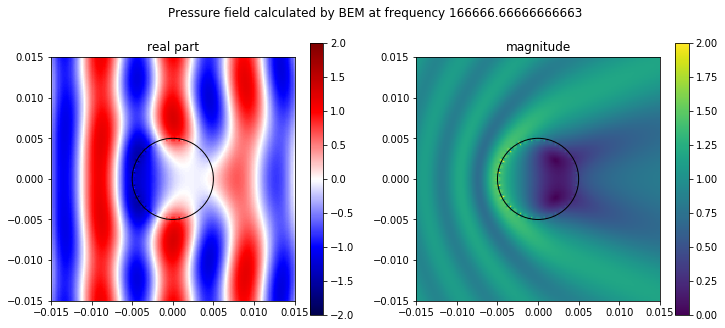

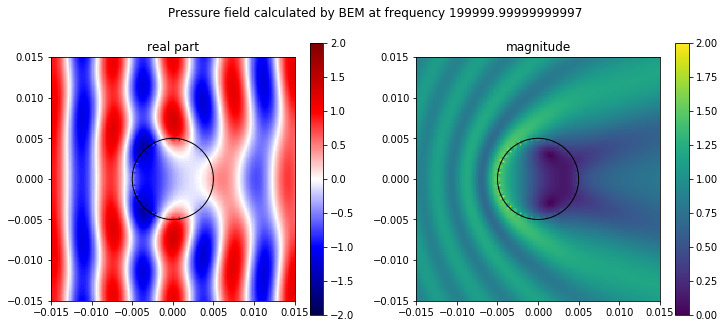

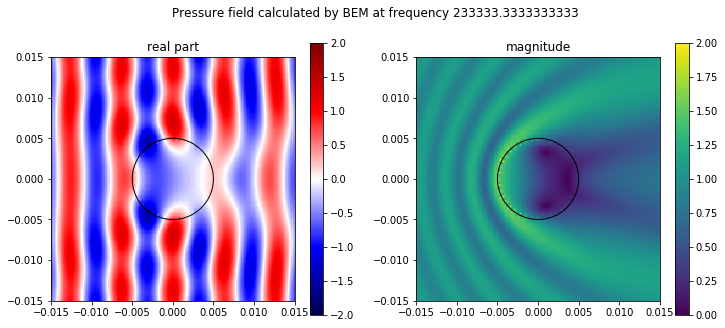

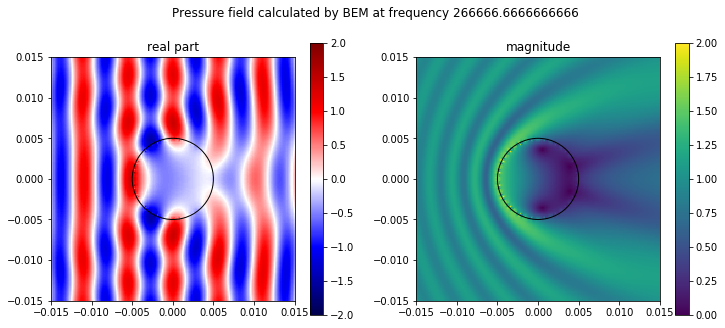

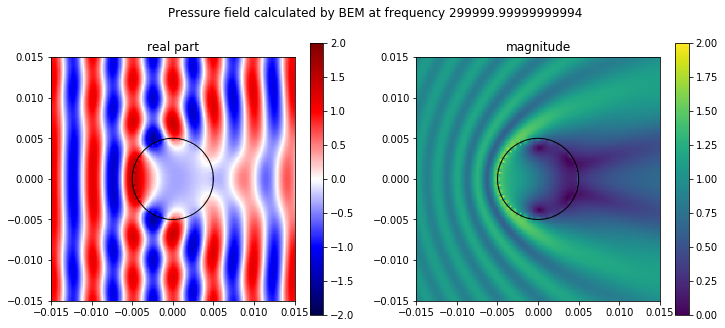

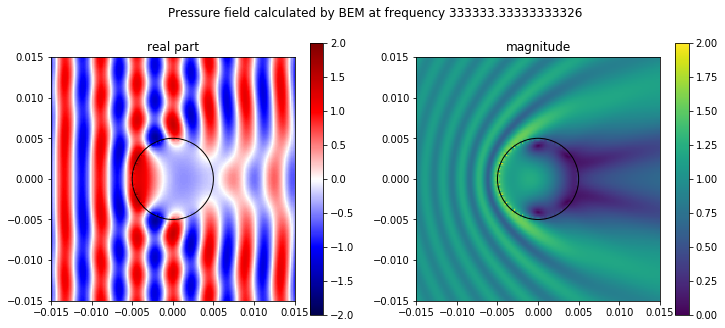

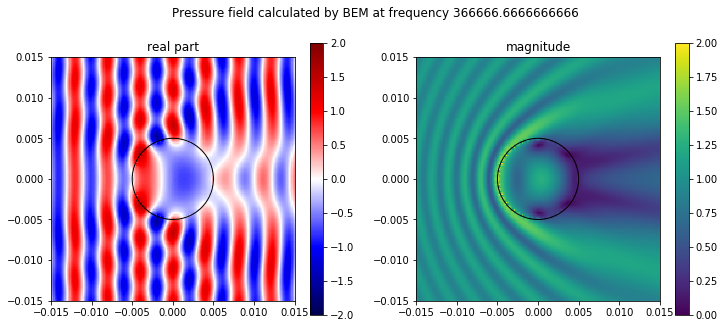

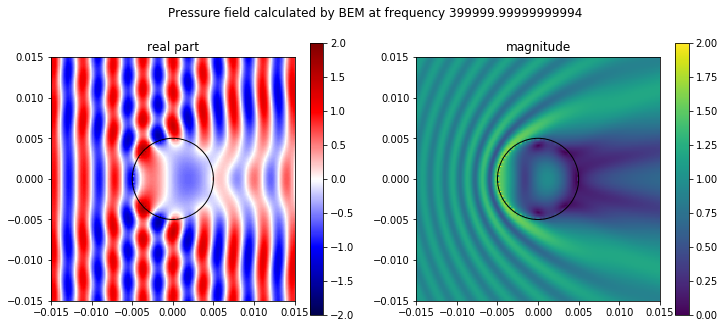

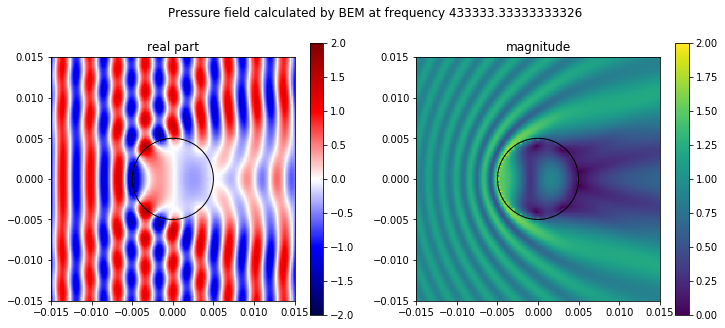

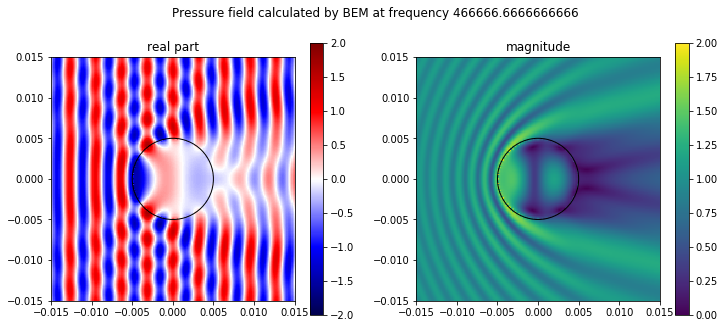

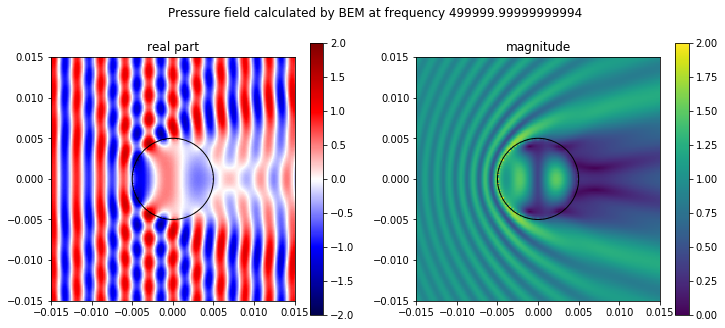

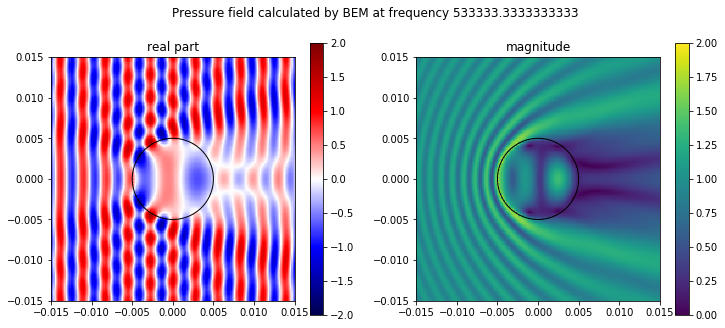

In [33]:
for count, field_plot in enumerate(fields_gaussian_tot):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

    im1 = ax1.imshow(np.real(field_plot), extent=EXTENT, clim=(-2, 2), cmap="seismic")
    ax1.add_artist(plt.Circle((0,0), RADIUS, edgecolor='k', fill=False))
    plt.colorbar(im1, ax=ax1)
    ax1.set_title('real part')

    im2 = ax2.imshow(np.abs(field_plot), extent=EXTENT, clim=(0, 2), cmap="viridis")
    ax2.add_artist(plt.Circle((0,0), RADIUS, edgecolor='k', fill=False))
    plt.colorbar(im2, ax=ax2)
    ax2.set_title('magnitude')

    fig.suptitle("Pressure field calculated by BEM at frequency "+str(freq_sweep[count]))

    plt.show()

### Perform Fourier analysis of the plane wave pulse

The temporal part of the incident wave field is a Gaussian modulated sinusoid with a bandlimited frequency content. The scattering of harmonic fields for the dominant frequencies was performed with the BEM. These results need to be combined within an inverse Fourier transform to calculate the scattering of a plane wave pulse at the geometry.

First, let us retrieve the incident wave field pulse via the inverse FFT to verify the procedure. Then, the total pressure field is calculated via the inverse FFT of the BEM results at each dominant frequency. For this purpose, the harmonic field from the BEM is multiplied with the FFT term at each frequency and then inverse Fourier transformed.

Notice that the complex conjugates are necessary due to the different sign conventions in BEMPP and NumPy.

In [34]:
incident_fields_bem_origin = np.zeros(RESOLUTION + freqs_fft.shape, dtype='complex')
for count, field_inc in enumerate(fields_gaussian_inc):
    idx_freq = idx_sweep[count]
    incident_fields_bem_origin[:, :, idx_freq] = field_inc * np.conj(pulse_gaussian_fft[idx_freq])

incident_fields_bem_ifft_origin = irfft(np.conj(incident_fields_bem_origin), axis=2)

In [35]:
pressure_fields_bem_origin = np.zeros(RESOLUTION + freqs_fft.shape, dtype='complex')
for count, field_gaussian in enumerate(fields_gaussian_tot):
    idx_freq = idx_sweep[count]
    pressure_fields_bem_origin[:, :, idx_freq] = field_gaussian * np.conj(pulse_gaussian_fft[idx_freq])

pressure_fields_bem_ifft_origin = irfft(np.conj(pressure_fields_bem_origin), axis=2)

Visualise the spatial-temporal fields in the spatial domain on a specific time interval. For this purpose, define the step size [s] and the length [s] for the plot.

In [36]:
plot_step = 0.5e-6
plot_length = 30e-6

In [37]:
from scipy.interpolate import interp1d

time_plot = np.arange(0, min(plot_length, time_samples[-1]), plot_step)

incident_fields_bem_time = interp1d(time_samples, incident_fields_bem_ifft_origin, axis=2, assume_sorted=True)
pressure_fields_bem_time = interp1d(time_samples, pressure_fields_bem_ifft_origin, axis=2, assume_sorted=True)

incident_fields_bem_time_plot = incident_fields_bem_time(time_plot)
pressure_fields_bem_time_plot = pressure_fields_bem_time(time_plot)

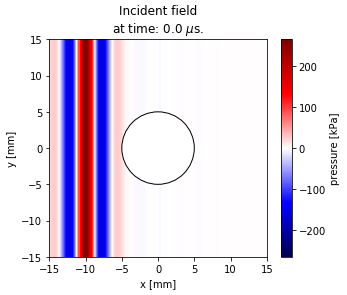

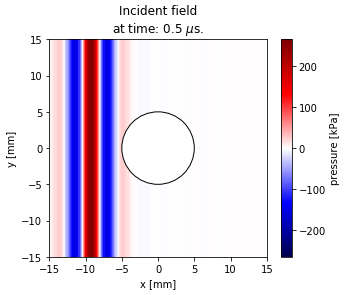

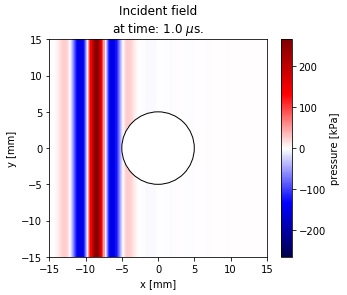

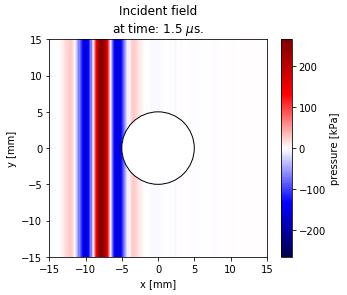

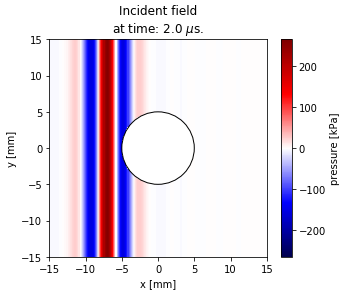

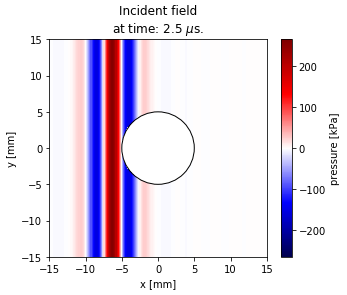

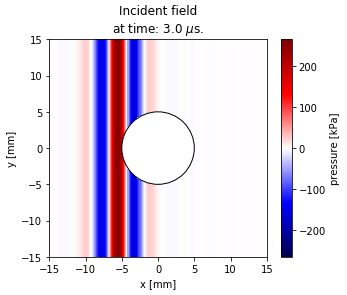

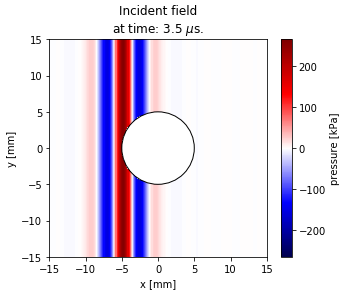

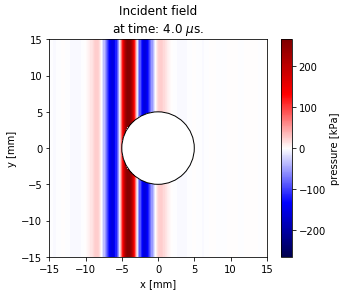

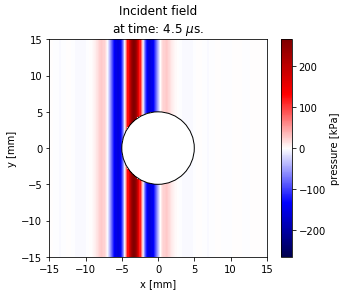

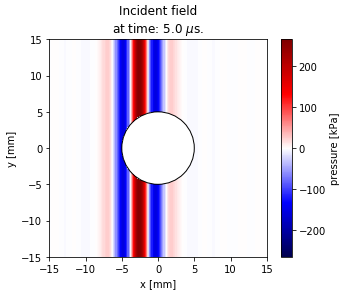

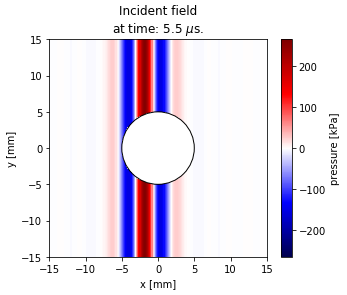

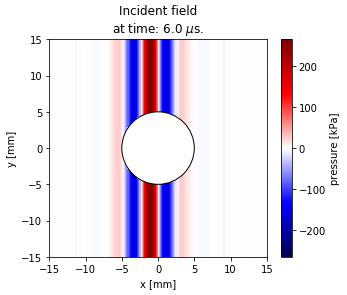

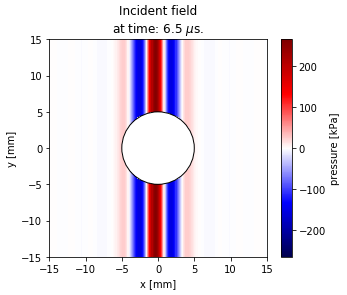

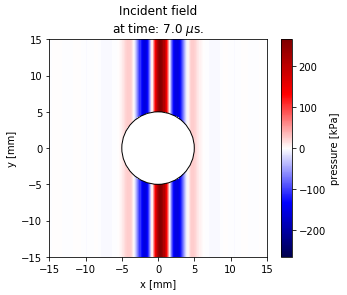

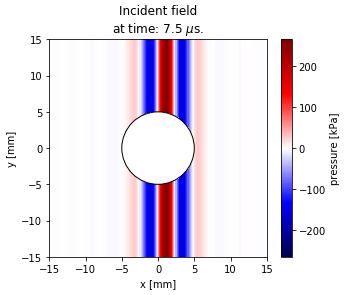

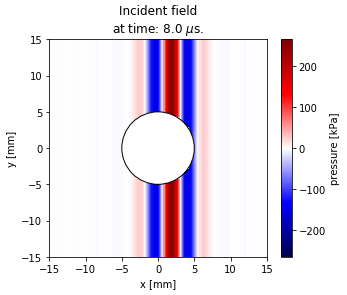

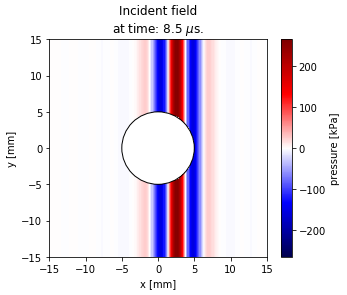

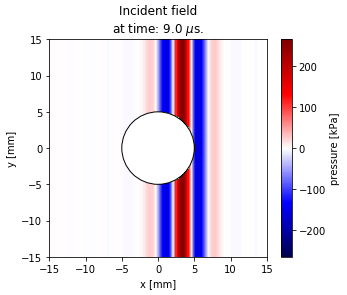

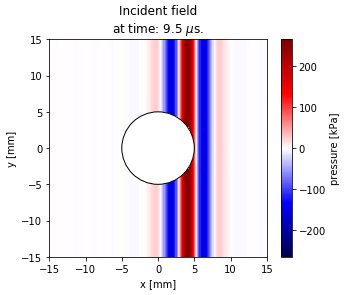

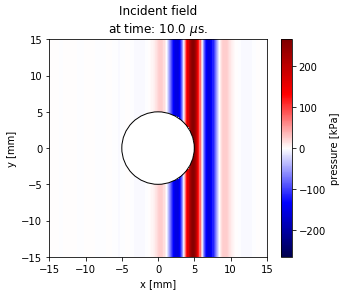

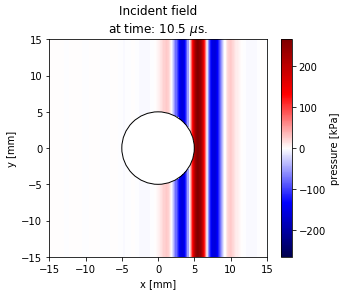

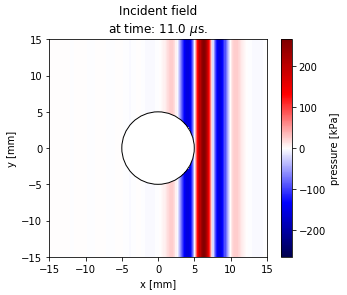

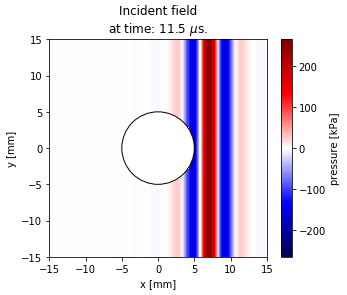

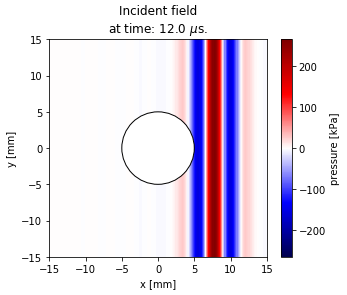

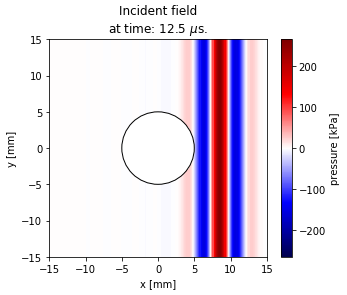

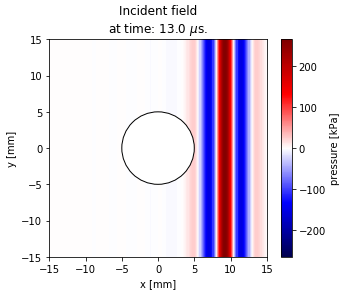

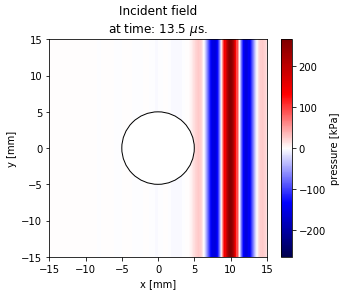

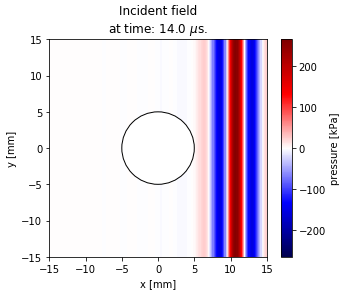

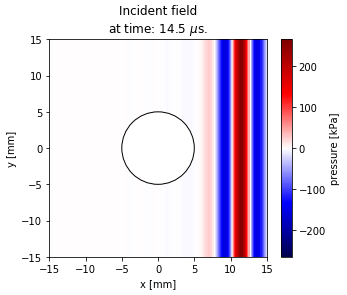

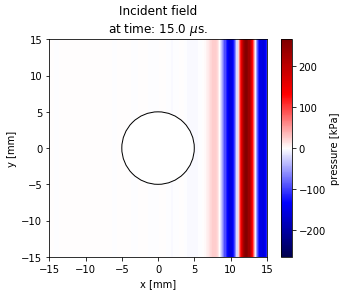

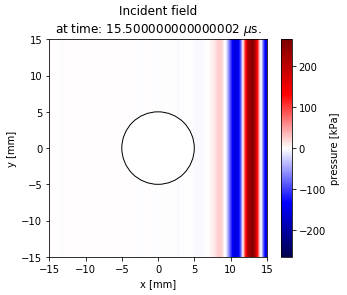

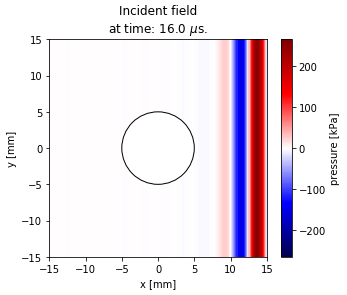

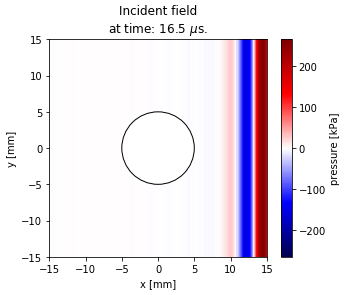

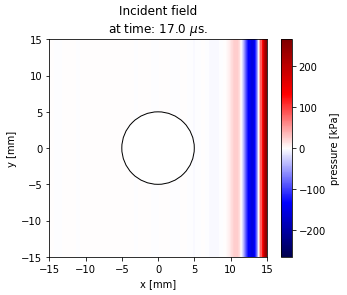

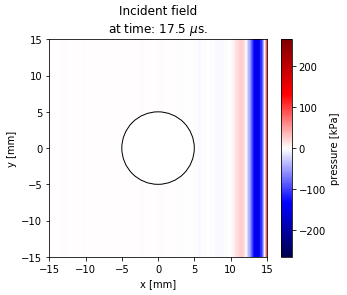

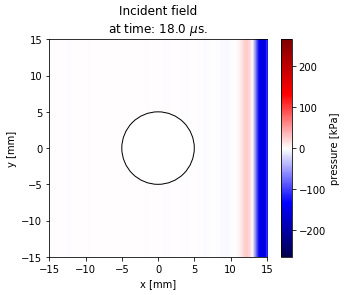

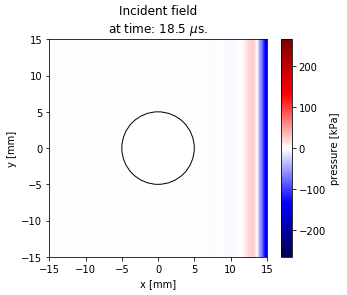

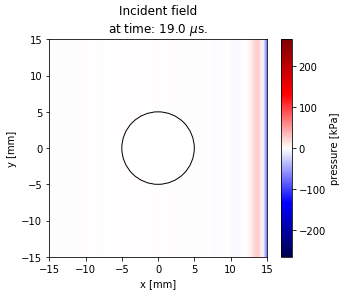

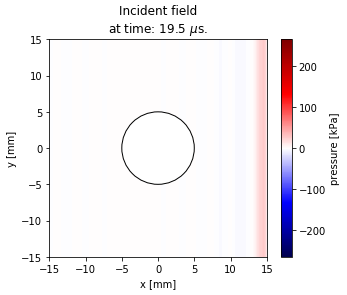

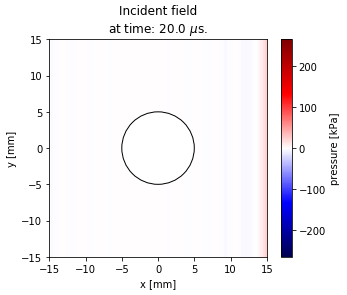

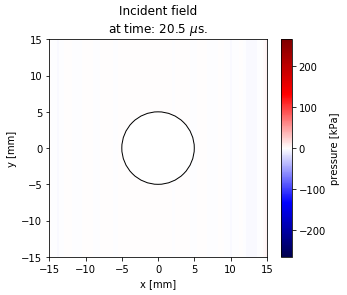

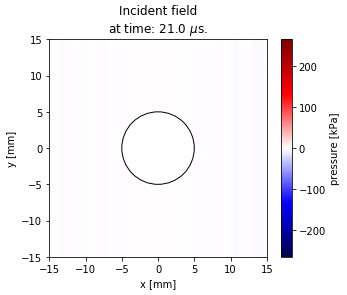

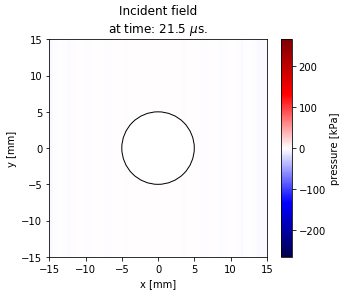

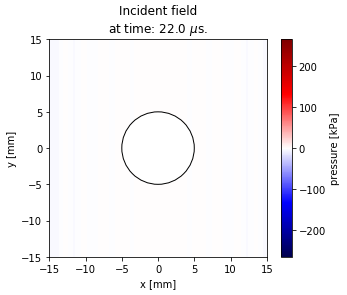

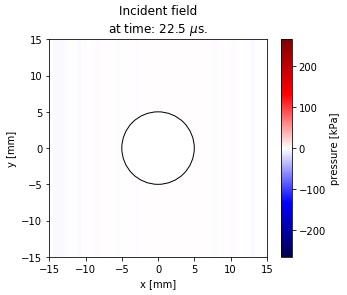

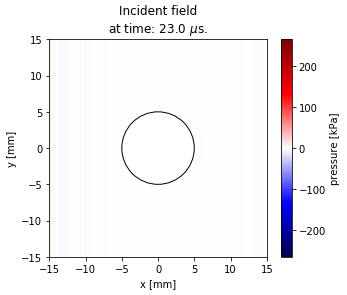

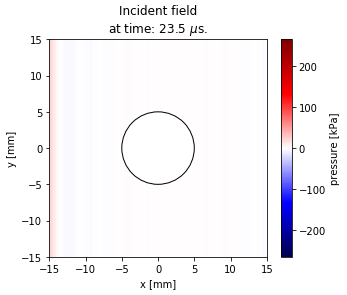

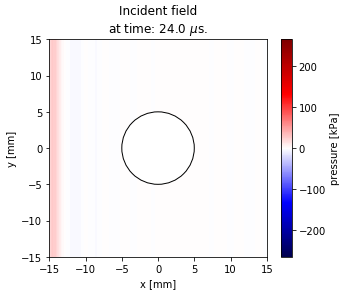

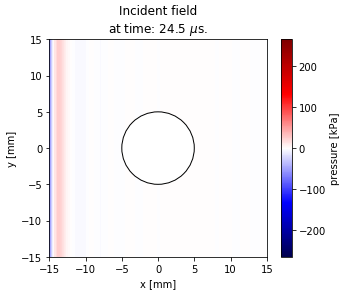

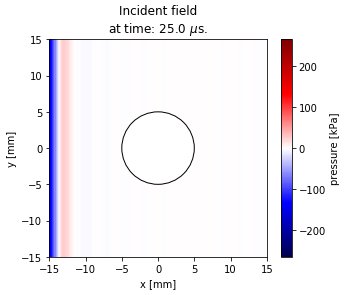

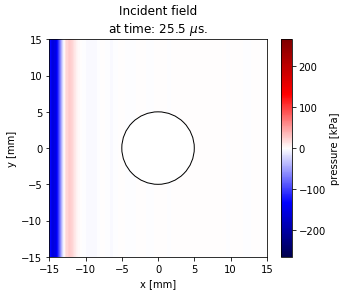

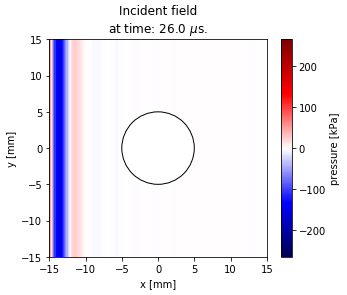

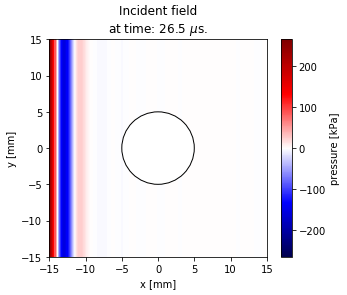

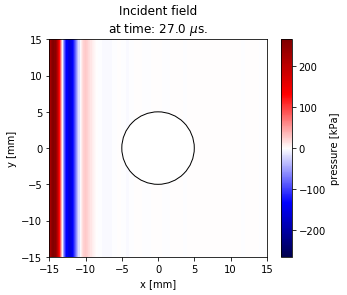

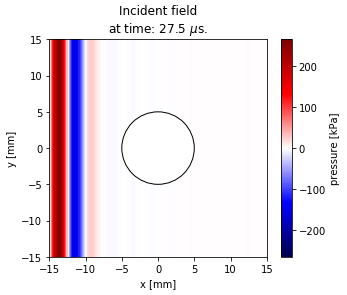

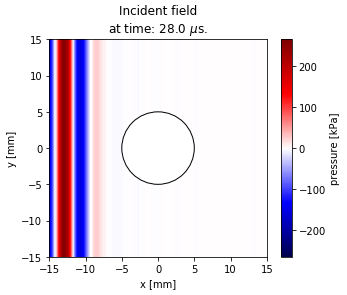

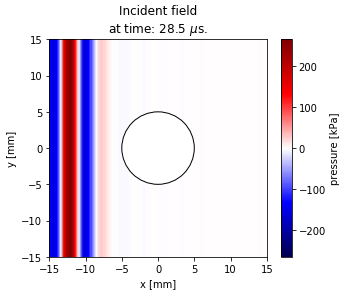

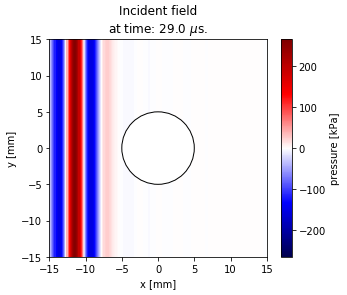

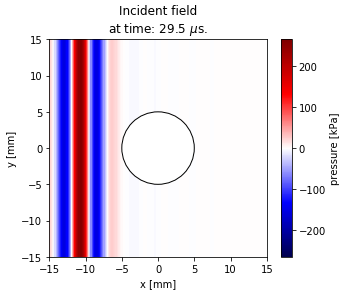

In [38]:
p_scaling = 1e3
d_scaling = 1e-3
t_scaling = 1e-6

clim = np.max(np.abs(pulse_gaussian_time))/p_scaling

for count, time in enumerate(time_plot):
    fig = plt.figure(figsize=(5,4))
    
    plt.imshow(incident_fields_bem_time_plot[:, :, count]/p_scaling, extent=np.array(EXTENT)/d_scaling, clim = (-clim, clim), cmap = "seismic")
    fig.gca().add_artist(plt.Circle((0,0), RADIUS/d_scaling, edgecolor='k', fill=False))

    plt.title("Incident field\nat time: "+str(time/t_scaling)+" $\mu$s.")
    plt.xlabel("x [mm]")
    plt.ylabel("y [mm]")
    plt.colorbar(label="pressure [kPa]")

    plt.show()

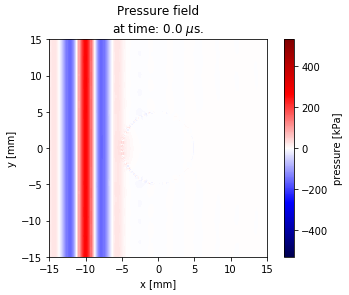

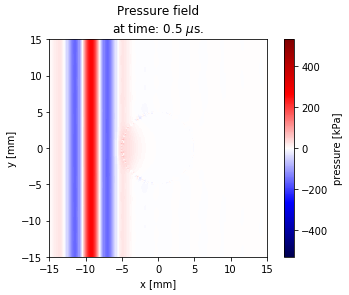

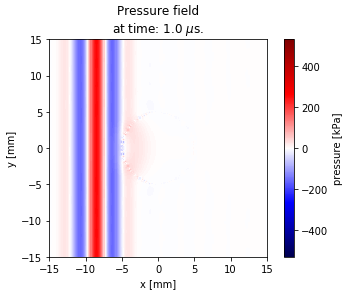

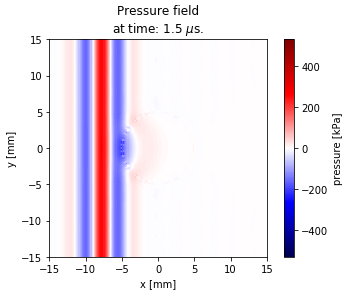

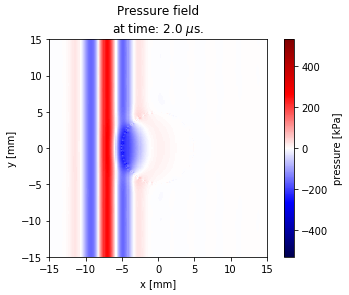

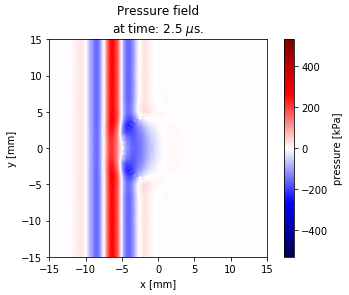

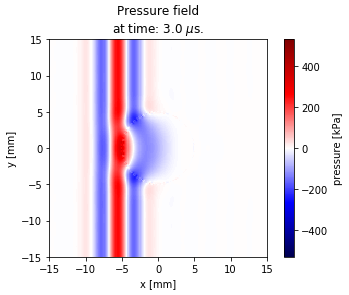

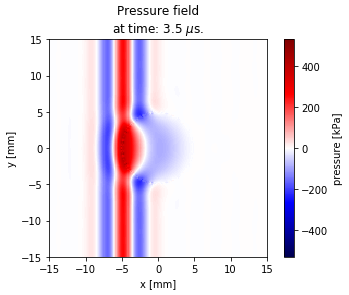

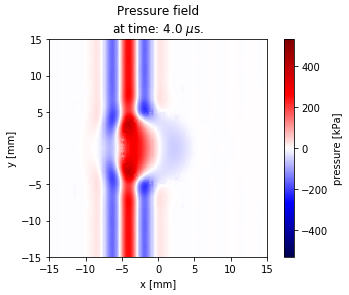

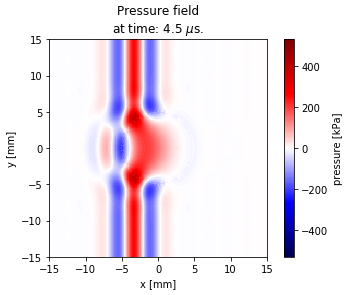

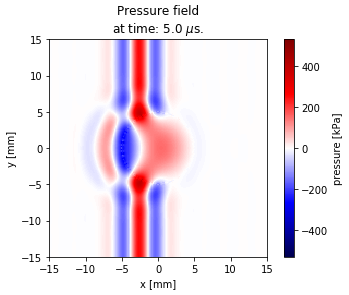

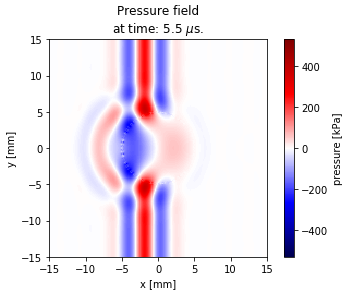

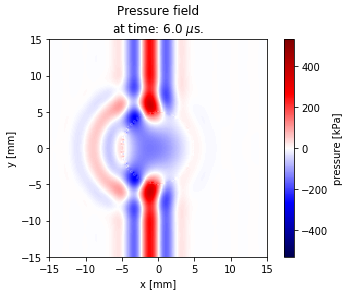

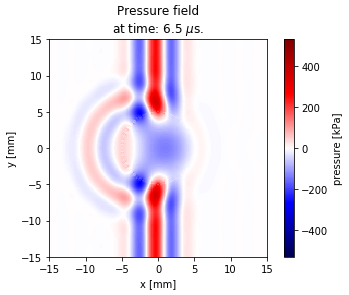

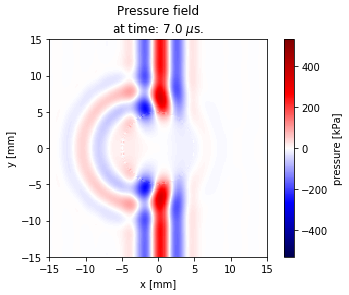

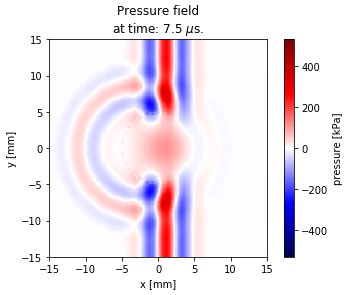

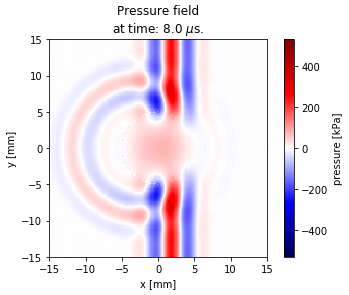

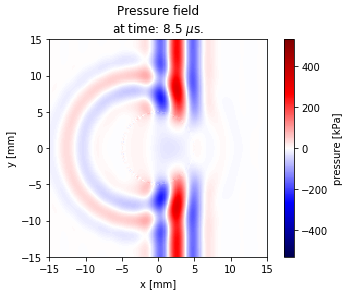

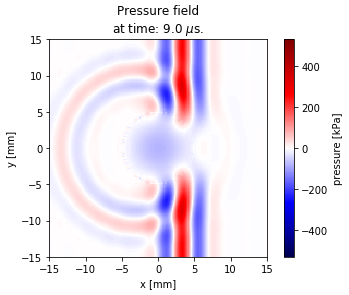

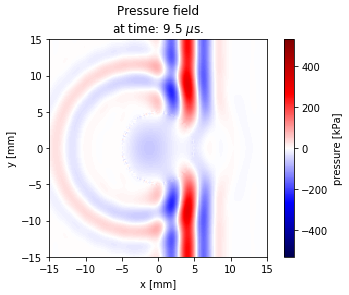

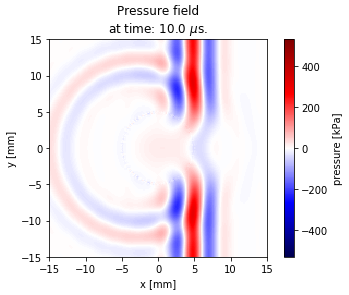

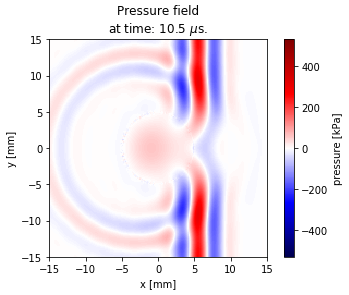

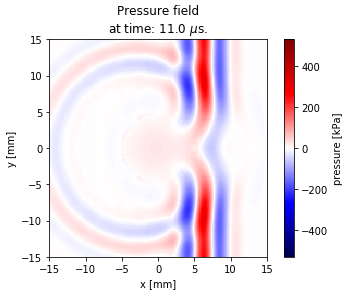

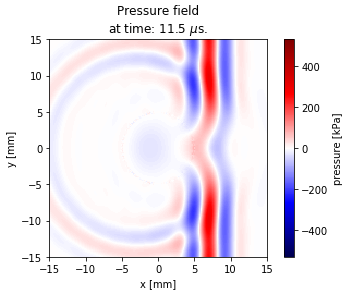

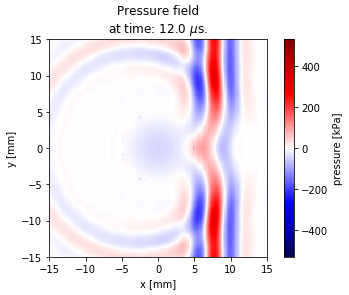

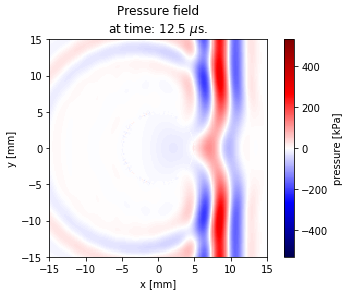

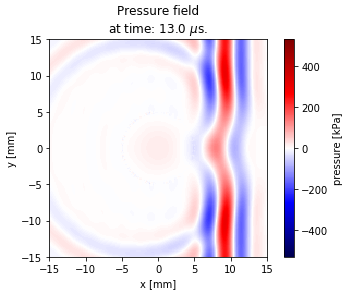

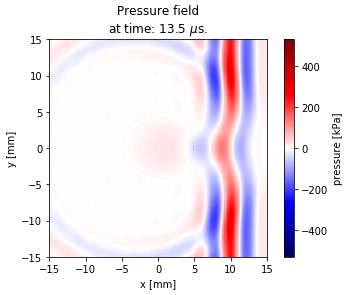

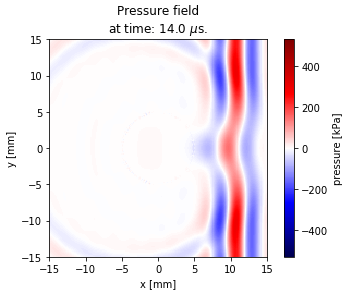

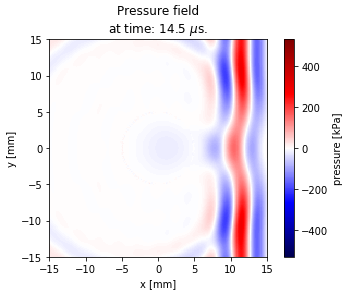

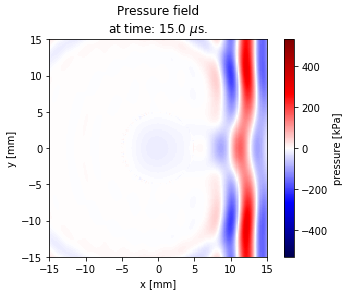

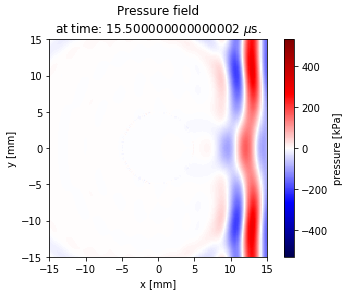

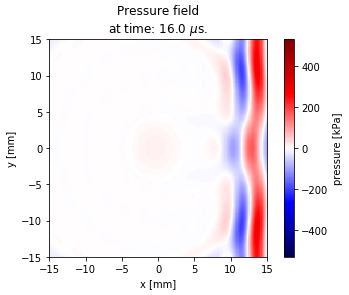

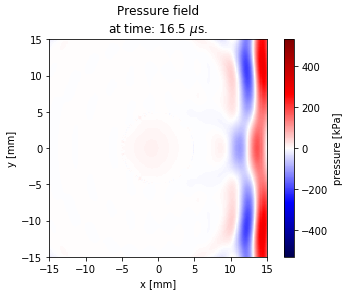

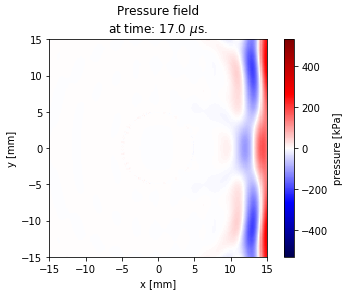

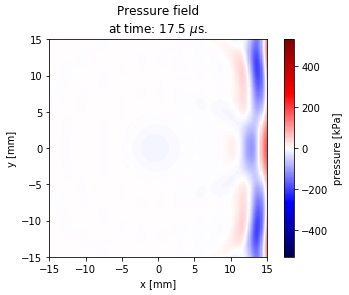

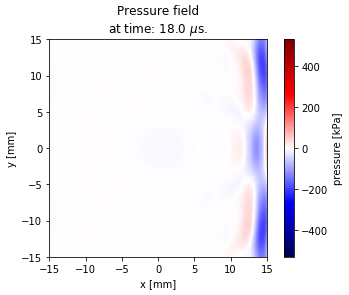

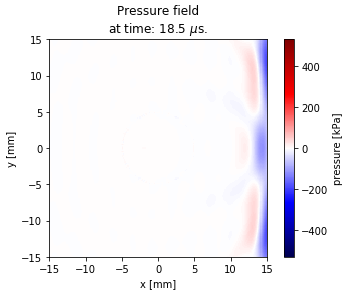

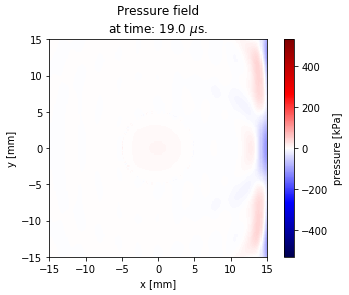

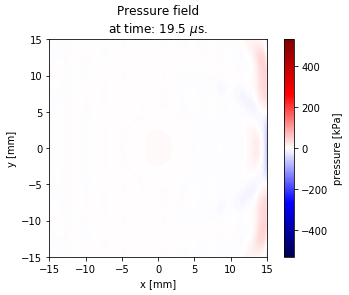

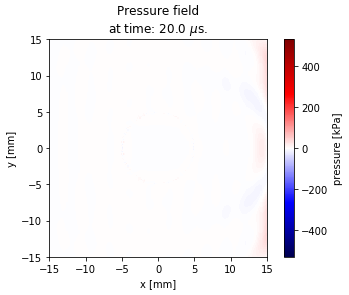

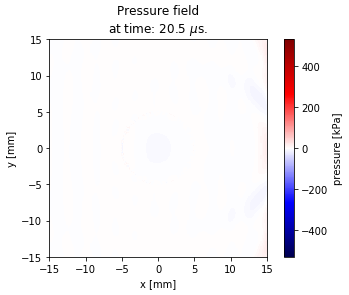

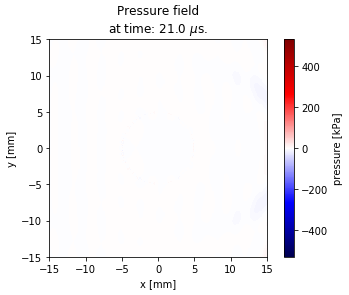

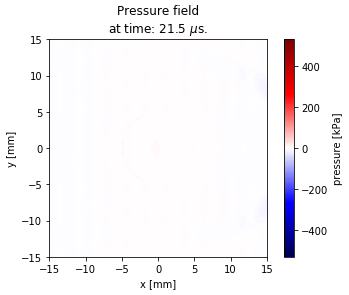

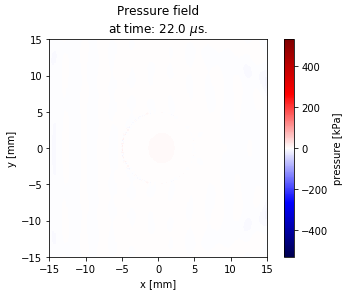

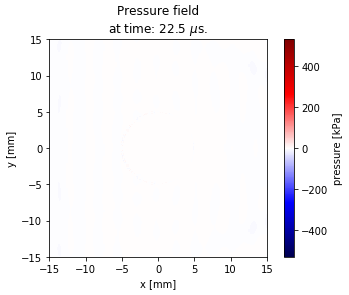

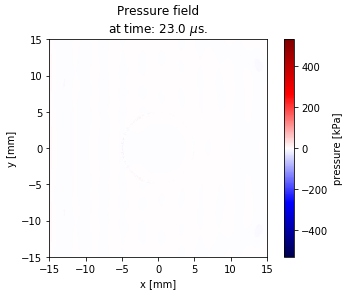

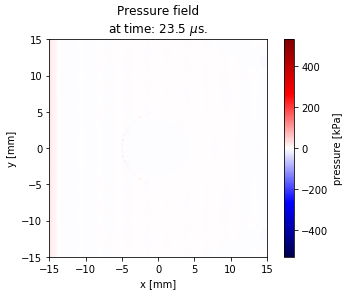

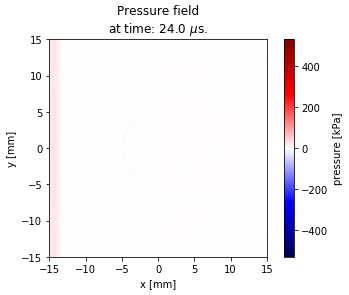

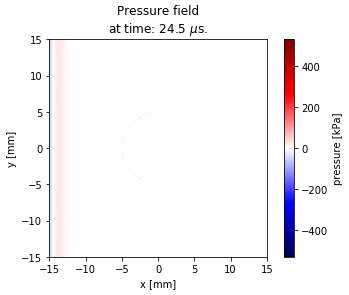

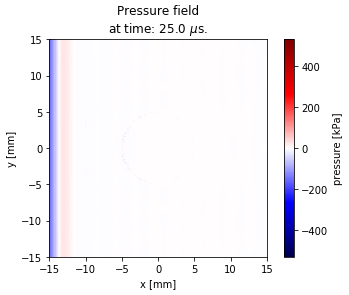

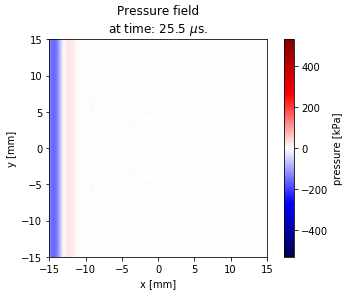

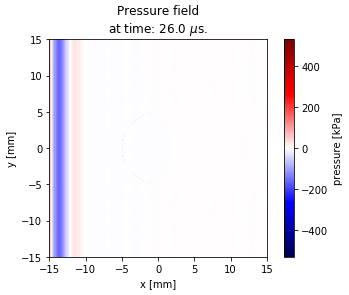

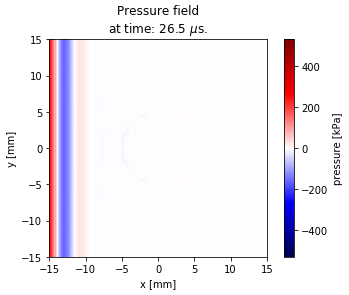

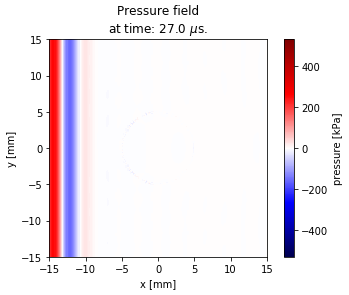

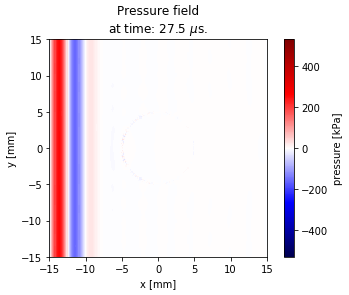

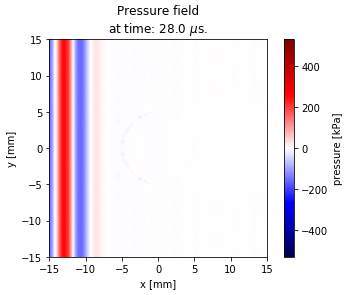

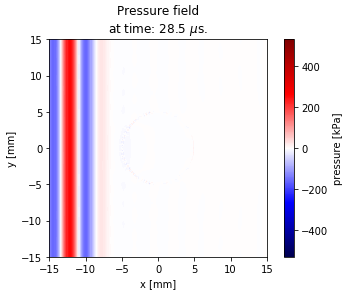

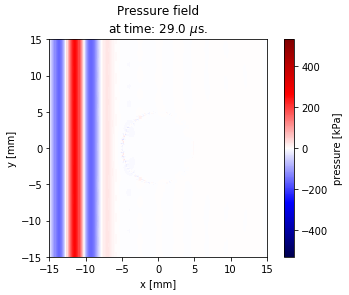

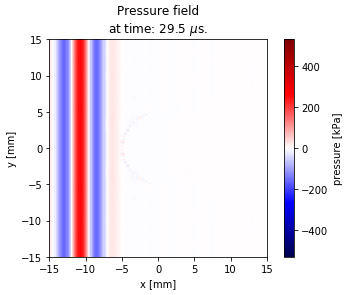

In [39]:
p_scaling = 1e3
d_scaling = 1e-3
t_scaling = 1e-6

clim = 2*np.max(np.abs(pulse_gaussian_time))/p_scaling

for count, time in enumerate(time_plot):
    
    plt.imshow(pressure_fields_bem_time_plot[:, :, count]/p_scaling, extent=np.array(EXTENT)/d_scaling, clim = (-clim, clim), cmap = "seismic")
    fig.gca().add_artist(plt.Circle((0,0), RADIUS/d_scaling, edgecolor='k', fill=False))

    plt.title("Pressure field\nat time: "+str(time/t_scaling)+" $\mu$s.")
    plt.xlabel("x [mm]")
    plt.ylabel("y [mm]")
    plt.colorbar(label="pressure [kPa]")

    plt.show()

This visualisation in time clearly shows the faster speed of sound in the interior bone region compared to the exterior water domain. Reflection of the pulse at the sphere is visible as well. Notice that the harmonic analysis is periodic, by definition, so that the incident pulse emerges again after one period. The length of the original time interval has to be chosen long enough to avoid spurious interaction due to the periodicity. 
Finally, the results can be displayed as an animated image and saved as a movie/gif/etc if needed.

<IPython.core.display.Javascript object>


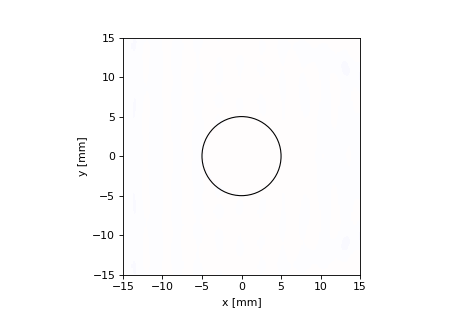

In [41]:
%matplotlib notebook
from matplotlib.animation import FuncAnimation

fig,ax = plt.subplots()
snapshots = np.asanyarray(pressure_fields_bem_time_plot[:, :, :]/p_scaling)
im = plt.imshow(snapshots[:,:,0],animated=True, extent=np.array(EXTENT)/d_scaling, clim = (-clim, clim), cmap = "seismic")
fig.gca().add_artist(plt.Circle((0,0), RADIUS/d_scaling, edgecolor='k', fill=False))

def animate(i):
    im.set_array(snapshots[:,:,i])
    ax.set_xlabel("x [mm]")
    ax.set_ylabel("y [mm]")
    

animated_fig = FuncAnimation(fig, animate, frames=len(time_plot), interval=200, blit=True)
plt.show()